# Modeling and Simulation in Python

Chapter 12

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code

Here's the code from the previous notebook that we'll need.

In [2]:
def make_system(beta, gamma, quarantine_rate):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, Q =0, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma, quarantine_rate=quarantine_rate)

In [3]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, q, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    quarantine_in = system.quarantine_rate * i 
    quarantine_out = q * system.quarantine_rate
    # Quarantine rate is the percentage of infected people who are moved in/out quarantine at any given time
    
    
    s -= infected
    i += infected - recovered - quarantine_in
    q += quarantine_in - quarantine_out
    r += recovered + quarantine_out
    
    return State(S=s, I=i, R=r)

In [4]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

### Metrics

Given the results, we can compute metrics that quantify whatever we are interested in, like the total number of sick students, for example.

In [5]:
def calc_total_infected(results):
    """Fraction of population infected during the simulation.
    
    results: DataFrame with columns S, I, R
    
    returns: fraction of population
    """
    return get_first_value(results.S) - get_last_value(results.S)

Here's an example.|

In [6]:
beta = 0.333
gamma = 0.25
quarantine_rate = 0.2
system = make_system(beta, gamma, quarantine_rate)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.028825497819311652


**Exercise:** Write functions that take a `TimeFrame` object as a parameter and compute the other metrics mentioned in the book:

1.  The fraction of students who are sick at the peak of the outbreak.

2.  The day the outbreak peaks.

3.  The fraction of students who are sick at the end of the semester.

Note: Not all of these functions require the `System` object, but when you write a set of related functons, it is often convenient if they all take the same parameters.

Hint:  If you have a `TimeSeries` called `I`, you can compute the largest value of the series like this:

    I.max()

And the index of the largest value like this:

    I.idxmax()

You can read about these functions in the `Series` [documentation](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.html).

I max: 0.011111111111111112 Q max: 0.0


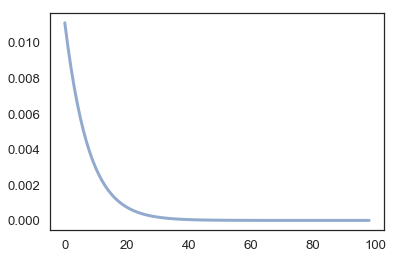

In [7]:
def get_fraction_sick(frame):
    frame_i_max = frame.I.max()
    frame_q_max = frame.Q.max()
    return frame_i_max, frame_q_max
frame_i_max, frame_q_max = get_fraction_sick(results)
print("I max:",frame_i_max,"Q max:", frame_q_max)
plot(results.index, results.I)
plot(results.index, results.Q)

In [8]:
def get_day_max_sick(frame):
    day = frame.I.idxmax()
    return day
day = get_day_max_sick(results)
print(day)

0


In [9]:
def get_fraction_end_semster(frame):
    last_day = frame.index.max()
    faction_sick_last_day = frame.I[last_day]
    return faction_sick_last_day
faction_sick_last_day = get_fraction_end_semster(results)
print(faction_sick_last_day)

1.3842397962082417e-08


### What if?

We can use this model to evaluate "what if" scenarios.  For example, this function models the effect of immunization by moving some fraction of the population from S to R before the simulation starts.

In [10]:
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

Let's start again with the system we used in the previous sections.

In [11]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma, quarantine_rate)

,values
init,S 0.988889 I 0.011111 Q 0.000000 R ...
t0,0
t_end,98
beta,0.333333
gamma,0.25
quarantine_rate,0.2


And run the model without immunization.

In [12]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.028924240092992992

Now with 10% immunization.

In [13]:
system2 = make_system(beta, gamma, quarantine_rate)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.020760278834450863

10% immunization leads to a drop in infections of 16 percentage points.

Here's what the time series looks like for S, with and without immunization.

Saving figure to file figs/chap05-fig02.pdf


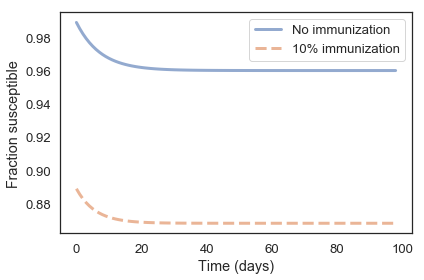

In [14]:
plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap05-fig02.pdf')

Now we can sweep through a range of values for the fraction of the population who are immunized.

In [15]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma, quarantine_rate)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.028924240092992992
0.1 0.020760278834450863
0.2 0.015298211749511514
0.30000000000000004 0.011407492922624107
0.4 0.008503133547980268
0.5 0.006255655309019892
0.6000000000000001 0.004466489593584255
0.7000000000000001 0.00300927025047526
0.8 0.0017999316138497257
0.9 0.0007804574095582328
1.0 -9.044381945998853e-05


This function does the same thing and stores the results in a `Sweep` object.

In [16]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma, quarantine_rate)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [17]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

,values
0.00,0.028924
0.05,0.024398
0.10,0.020760
0.15,0.017780
0.20,0.015298
0.25,0.013201
0.30,0.011407
0.35,0.009857
0.40,0.008503
0.45,0.007312


And here's what the results look like.

Saving figure to file figs/chap05-fig03.pdf


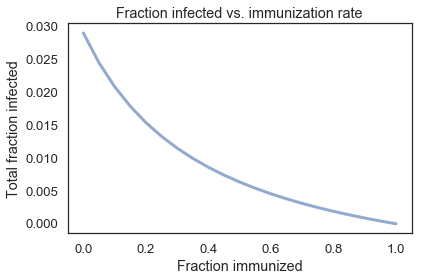

In [18]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap05-fig03.pdf')

If 40% of the population is immunized, less than 4% of the population gets sick.

### Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [19]:
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [20]:
spending = linspace(0, 1200, 21)

array([   0.,   60.,  120.,  180.,  240.,  300.,  360.,  420.,  480.,
        540.,  600.,  660.,  720.,  780.,  840.,  900.,  960., 1020.,
       1080., 1140., 1200.])

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [21]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

Saving figure to file figs/chap05-fig04.pdf


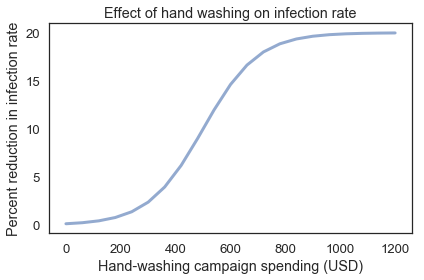

In [22]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)

savefig('figs/chap05-fig04.pdf')

**Exercise:** Modify the parameters `M`, `K`, and `B`, and see what effect they have on the shape of the curve.  Read about the [generalized logistic function on Wikipedia](https://en.wikipedia.org/wiki/Generalised_logistic_function).  Modify the other parameters and see what effect they have.

### Hand washing

Now we can model the effect of a hand-washing campaign by modifying `beta`

In [23]:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Let's start with the same values of `beta` and `gamma` we've been using.

In [24]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

Now we can sweep different levels of campaign spending.

In [25]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma, quarantine_rate)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3328871432717143 0.02879216902671411
100.0 0.3321342526691939 0.028571141204431272
200.0 0.33017160845482885 0.0280055298128844
300.0 0.32538647186519215 0.026687610099319747
400.0 0.3154039052420003 0.024190236613685134
500.0 0.3 0.020896773463677132
600.0 0.28459609475799963 0.018143498214402864
700.0 0.2746135281348078 0.016590473671873496
800.0 0.26982839154517113 0.015901164664747225
900.0 0.2678657473308061 0.015627945285081934
1000.0 0.26711285672828566 0.015524549911553165
1100.0 0.26683150821044227 0.015486110392342822
1200.0 0.26672740341296003 0.015471914183988189


Here's a function that sweeps a range of spending and stores the results in a `SweepSeries`.

In [26]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma, quarantine_rate)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

Here's how we run it.

In [27]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

,values
0.000000,0.028792
63.157895,0.028678
126.315789,0.028468
189.473684,0.028092
252.631579,0.027439
315.789474,0.026377
378.947368,0.024816
442.105263,0.022831
505.263158,0.020727
568.421053,0.018887


And here's what it looks like.

Saving figure to file figs/chap05-fig05.pdf


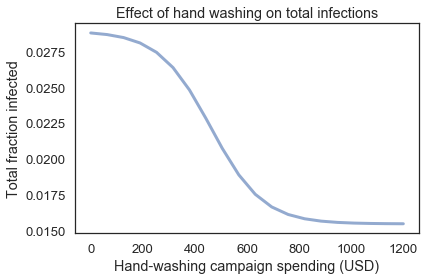

In [28]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap05-fig05.pdf')

Now let's put it all together to make some public health spending decisions.

### Optimization

Suppose we have \$1200 to spend on any combination of vaccines and a hand-washing campaign.

In [29]:
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses, endpoint=True)
max_doses

24

We can sweep through a range of doses from, 0 to `max_doses`, model the effects of immunization and the hand-washing campaign, and run simulations.

For each scenario, we compute the fraction of students who get sick.

In [30]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma, quarantine_rate)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results, run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

0 0.9888888888888889 0.26672740341296003 0.015471914183988189
1 0.9777777777777779 0.26676674548378243 0.015471914183988189
2 0.9666666666666667 0.26683150821044227 0.015471914183988189
3 0.9555555555555556 0.2669380091810597 0.015471914183988189
4 0.9444444444444445 0.26711285672828566 0.015471914183988189
5 0.9333333333333333 0.2673991295087062 0.015471914183988189
6 0.9222222222222223 0.2678657473308061 0.015471914183988189
7 0.9111111111111112 0.26862081538342375 0.015471914183988189
8 0.9 0.26982839154517113 0.015471914183988189
9 0.888888888888889 0.2717238786680829 0.015471914183988189
10 0.8777777777777778 0.2746135281348078 0.015471914183988189
11 0.8666666666666667 0.27882836825375706 0.015471914183988189
12 0.8555555555555556 0.28459609475799963 0.015471914183988189
13 0.8444444444444446 0.291836044586543 0.015471914183988189
14 0.8333333333333334 0.3 0.015471914183988189
15 0.8222222222222223 0.308163955413457 0.015471914183988189
16 0.8111111111111111 0.3154039052420003 0.

The following function wraps that loop and stores the results in a `Sweep` object.

In [31]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma, quarantine_rate)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

Now we can compute the number of infected students for each possible allocation of the budget.

In [32]:
infected_sweep = sweep_doses(dose_array)

,values
0,0.015472
1,0.015072
2,0.014687
3,0.014317
4,0.013965
5,0.013635
6,0.013332
7,0.013065
8,0.012848
9,0.012699


And plot the results.

Saving figure to file figs/chap05-fig06.pdf


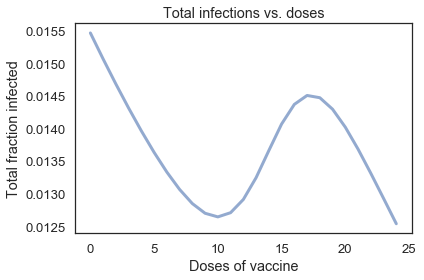

In [33]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap05-fig06.pdf')

### Exercises

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

**Exercise:** Suppose we have the option to quarantine infected students.  For example, a student who feels ill might be moved to an infirmary, or a private dorm room, until they are no longer infectious.

How might you incorporate the effect of quarantine in the SIR model?

In [34]:
# Instead of copying the code back down here, I just changed the value in the code up above